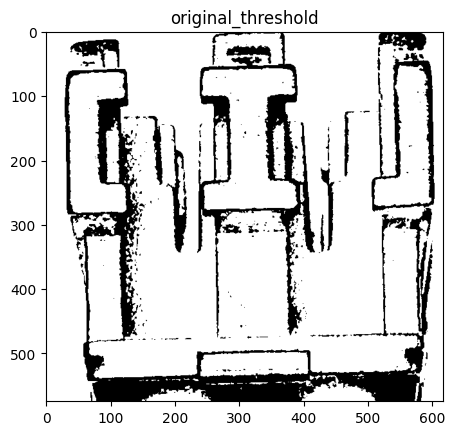

In [1014]:
# DWT for denoise
image = cv2.imread("/Users/laiyiying/Documents/110-image/IMG_4922.jpg")
image = cv2.GaussianBlur(image, (3,3),0)
#image = cv2.resize(image, (300, 300), interpolation=cv2.INTER_LINEAR)
image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
_,re_img_hist_t =  cv2.threshold(image, 110, 255, cv2.THRESH_BINARY)
plt.title("original_threshold")
plt.imshow(re_img_hist_t, cmap='gray', vmin = 0, vmax = 255)
plt.show()

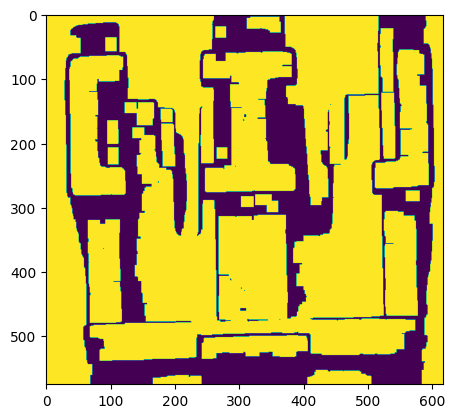

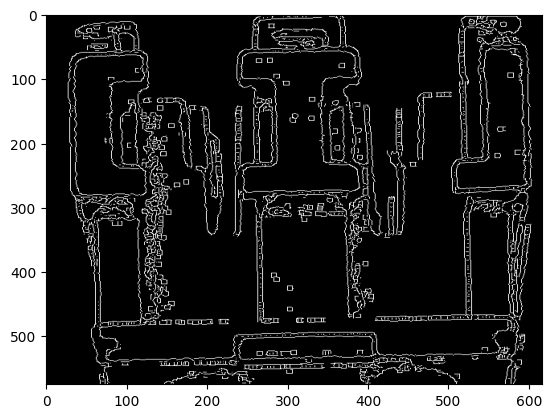

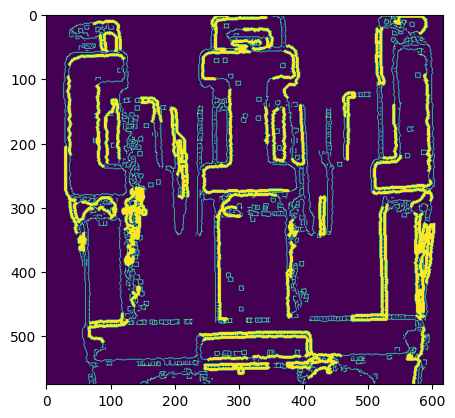

In [1016]:
blurred =cv2.GaussianBlur(re_img_hist_t, (7,7),9)
closed = cv2.morphologyEx(re_img_hist_t, cv2.MORPH_OPEN, kernel, iterations=4)
plt.imshow(closed)
plt.show()
canny = cv2.Canny(closed, 20, 30)
plt.imshow(canny, cmap='gray', vmin = 0, vmax = 255, aspect='auto')
plt.show()

contours1,hierarchy = cv2.findContours(canny,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
contours = [contour for contour in contours1 if len(contour)>60]
CountersImg = cv2.drawContours(canny,contours, -1, (255,255,0),3)
plt.imshow(CountersImg)
plt.show()

In [ ]:
import numpy as np
import scipy.linalg
from scipy.interpolate import RectBivariateSpline
from skimage.util import img_as_float
from skimage.filters import sobel
def active_contour(image, snake, alpha=0.01, beta=0.5,
w_line=0, w_edge=1, gamma=0.01,
bc='periodic', max_px_move=1.0,
max_iterations=10000, convergence=0.5):
    scipy_version = list(map(int, scipy.__version__.split('.')))
    new_scipy = scipy_version[0] > 0 or \
                (scipy_version[0] == 0 and scipy_version[1] >= 14)
    if not new_scipy:
        raise NotImplementedError('You are using an old version of scipy. '
                      'Active contours is implemented for scipy versions '
                      '0.14.0 and above.')

    max_iterations = int(max_iterations)
    if max_iterations <= 0:
        raise ValueError("max_iterations should be >0.")
    convergence_order = 10
    valid_bcs = ['periodic', 'free', 'fixed', 'free-fixed',
                 'fixed-free', 'fixed-fixed', 'free-free']
    if bc not in valid_bcs:
        raise ValueError("Invalid boundary condition.\n" +
                         "Should be one of: "+", ".join(valid_bcs)+'.')
    img = img_as_float(image)
    RGB = img.ndim == 3

    # Find edges using sobel:
    if w_edge != 0:
        if RGB:
            edge = [sobel(img[:, :, 0]), sobel(img[:, :, 1]),
                    sobel(img[:, :, 2])]
        else:
            edge = [sobel(img)]
        for i in range(3 if RGB else 1):
            edge[i][0, :] = edge[i][1, :]
            edge[i][-1, :] = edge[i][-2, :]
            edge[i][:, 0] = edge[i][:, 1]
            edge[i][:, -1] = edge[i][:, -2]
    else:
        edge = [0]

    # Superimpose intensity and edge images:
    if RGB:
        img = w_line*np.sum(img, axis=2) \
            + w_edge*sum(edge)
    else:
        img = w_line*img + w_edge*edge[0]

    # Interpolate for smoothness:
    if new_scipy:
        intp = RectBivariateSpline(np.arange(img.shape[1]),
                                   np.arange(img.shape[0]),
                                   img.T, kx=2, ky=2, s=0)
    else:
        intp = np.vectorize(interp2d(np.arange(img.shape[1]),
                        np.arange(img.shape[0]), img, kind='cubic',
                        copy=False, bounds_error=False, fill_value=0))

    x, y = snake[:, 0].copy(), snake[:, 1].copy()
    xsave = np.empty((convergence_order, len(x)))
    ysave = np.empty((convergence_order, len(x)))

    # Build snake shape matrix for Euler equation
    n = len(x)
    a = np.roll(np.eye(n), -1, axis=0) + \
        np.roll(np.eye(n), -1, axis=1) - \
        2*np.eye(n)  # second order derivative, central difference
    b = np.roll(np.eye(n), -2, axis=0) + \
        np.roll(np.eye(n), -2, axis=1) - \
        4*np.roll(np.eye(n), -1, axis=0) - \
        4*np.roll(np.eye(n), -1, axis=1) + \
        6*np.eye(n)  # fourth order derivative, central difference
    A = -alpha*a + beta*b

    # Impose boundary conditions different from periodic:
    sfixed = False
    if bc.startswith('fixed'):
        A[0, :] = 0
        A[1, :] = 0
        A[1, :3] = [1, -2, 1]
        sfixed = True
    efixed = False
    if bc.endswith('fixed'):
        A[-1, :] = 0
        A[-2, :] = 0
        A[-2, -3:] = [1, -2, 1]
        efixed = True
    sfree = False
    if bc.startswith('free'):
        A[0, :] = 0
        A[0, :3] = [1, -2, 1]
        A[1, :] = 0
        A[1, :4] = [-1, 3, -3, 1]
        sfree = True
    efree = False
    if bc.endswith('free'):
        A[-1, :] = 0
        A[-1, -3:] = [1, -2, 1]
        A[-2, :] = 0
        A[-2, -4:] = [-1, 3, -3, 1]
        efree = True

    # Only one inversion is needed for implicit spline energy minimization:
    inv = scipy.linalg.inv(A+gamma*np.eye(n))

    # Explicit time stepping for image energy minimization:
    for i in range(max_iterations):
        if new_scipy:
            fx = intp(x, y, dx=1, grid=False)
            fy = intp(x, y, dy=1, grid=False)
        else:
            fx = intp(x, y, dx=1)
            fy = intp(x, y, dy=1)
        if sfixed:
            fx[0] = 0
            fy[0] = 0
        if efixed:
            fx[-1] = 0
            fy[-1] = 0
        if sfree:
            fx[0] *= 2
            fy[0] *= 2
        if efree:
            fx[-1] *= 2
            fy[-1] *= 2
        xn = np.dot(inv, gamma*x + fx)
        yn = np.dot(inv, gamma*y + fy)

        # Movements are capped to max_px_move per iteration:
        dx = max_px_move*np.tanh(xn-x)
        dy = max_px_move*np.tanh(yn-y)
        if sfixed:
            dx[0] = 0
            dy[0] = 0
        if efixed:
            dx[-1] = 0
            dy[-1] = 0
        x[:] += dx
        y[:] += dy

        # Convergence criteria needs to compare to a number of previous
        # configurations since oscillations can occur.
        j = i % (convergence_order+1)
        if j < convergence_order:
            xsave[j, :] = x
            ysave[j, :] = y
        else:
            dist = np.min(np.max(np.abs(xsave-x[None, :]) +
                   np.abs(ysave-y[None, :]), 1))
            if dist < convergence:
                break

    return np.array([x, y]).T

[[ 75.         260.        ]
 [ 76.12244898 260.        ]
 [ 77.24489796 260.        ]
 ...
 [ 65.         256.12244898]
 [ 65.         255.56122449]
 [ 65.         255.        ]]


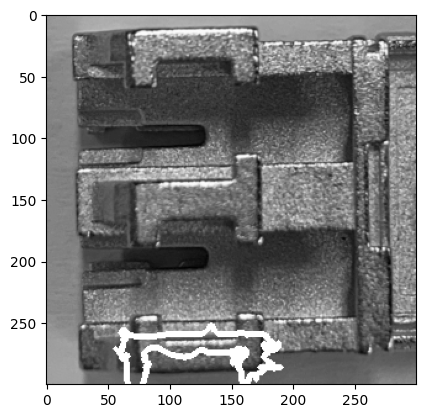

In [894]:
s = np.linspace(0, 110,99)
initx = np.array([s+75,180+0*s,180-0.15*s,155+0*s,160-0.8*s,80+0*s,80-0.15*s,65+0*s]).T
inity = np.array([20+0*s,20+0.30*s,50+0*s, 50-0.15*s,35+0*s,35+0.35*s,70+0*s,70-0.5*s]).T+240
init0 = np.array([initx, inity]).T .reshape(-1,2)
print(init0)
init = np.array([55*np.cos(s)+100, 8*np.sin(s)]).T+20
#print(init)
snake = active_contour(re_img_hist_t , init0, w_edge=0, w_line=1)
snake = snake.astype(np.int32).reshape(-1,1,2)

#drawing = np.zeros((re_img.shape[0], re_img.shape[1], 3), dtype=np.uint8)
image_draw = image.copy()
CountersImg = cv2.drawContours(image_draw,[snake], -1, (255,255,0),3)
plt.imshow(CountersImg,cmap=plt.cm.gray)
plt.show()

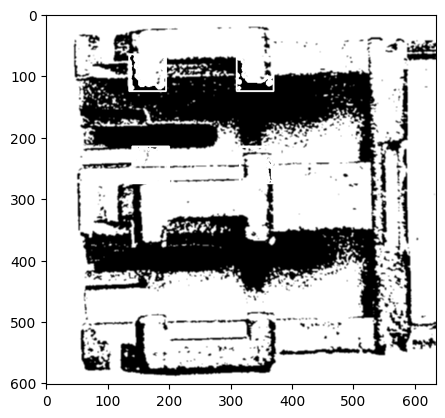

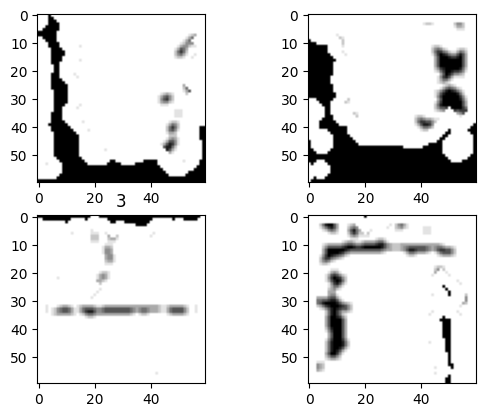

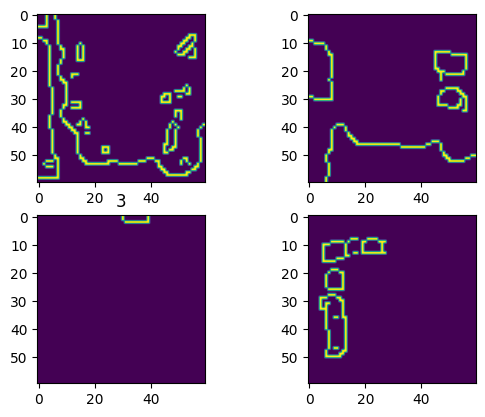

In [957]:
start_point1 = (135, 65)
end_point1 = (195,125)
color = (255, 0, 0)

start_point2 = (310, 65)
end_point2 = (370,125)
color = (255, 0, 0)

start_point3 = (140, 215)
end_point3 = (200,275)
color = (255, 0, 0)

start_point4 = (315, 215)
end_point4 = (375,275)
color = (255, 0, 0)

# Line thickness of 2 px
thickness = 2
rect = blurred .copy()  
# Using cv2.rectangle() method
# Draw a rectangle with blue line borders of thickness of 2 px
image_rect = cv2.rectangle(rect, start_point1, end_point1, color, thickness)
image_rect = cv2.rectangle(image_rect, start_point2, end_point2, color, thickness)
image_rect = cv2.rectangle(image_rect, start_point3, end_point3, color, thickness)
image_rect = cv2.rectangle(image_rect, start_point4, end_point4, color, thickness)
plt.imshow(image_rect,cmap=plt.cm.gray)
plt.show()  


image1 = blurred[start_point1[1]:end_point1[1],start_point1[0]:end_point1[0]]
image2 = blurred [start_point2[1]:end_point2[1],start_point2[0]:end_point2[0]]
image3 = blurred [start_point3[1]:end_point3[1],start_point3[0]:end_point3[0]]
image4 = blurred [start_point4[1]:end_point4[1],start_point4[0]:end_point4[0]]
images = [image1,image2,image3,image4]
labels = ["Normal","Normal","Missed","Normal"]
plt.subplot(221)  
plt.imshow(image1,cmap=plt.cm.gray)
#作图2
plt.subplot(222)  
plt.imshow(image2,cmap=plt.cm.gray) 
 #作图3
plt.subplot(223)  
plt.plot(x, x ** 2)  
plt.title("3")
plt.imshow(image3,cmap=plt.cm.gray)
#作图4
plt.subplot(224)  
plt.imshow(image4,cmap=plt.cm.gray)
plt.show()  
kernel = np.ones((5,5), np.uint8)
image1 = cv2.morphologyEx(image1, cv2.MORPH_OPEN, kernel, iterations=1)
image1 = cv2.Canny(image1, 20, 30)
contours1,hierarchy = cv2.findContours(image1,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
CountersImg1 = cv2.drawContours(image1,contours1, -1, (255,255,0),1)
image2 = cv2.morphologyEx(image2, cv2.MORPH_CLOSE, kernel, iterations=1)
image2 = cv2.Canny(image2, 20, 30)
contours2,hierarchy = cv2.findContours(image2,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
CountersImg2 = cv2.drawContours(image2,contours2, -1, (255,255,0),1)
image3 = cv2.morphologyEx(image3, cv2.MORPH_CLOSE, kernel, iterations=1)
image3 = cv2.Canny(image3, 20, 30)
contours3,hierarchy = cv2.findContours(image3,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
CountersImg3 = cv2.drawContours(image3,contours3, -1, (255,255,0),1)
image4 = cv2.morphologyEx(image4, cv2.MORPH_CLOSE, kernel, iterations=1)
image4 = cv2.Canny(image4, 20, 30)
contours4,hierarchy = cv2.findContours(image4,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
CountersImg4 = cv2.drawContours(image4,contours4, -1, (255,255,0),1)
plt.subplot(221)  
plt.imshow(CountersImg1)
#作图2
plt.subplot(222)  
plt.imshow(CountersImg2) 
 #作图3
plt.subplot(223)  
plt.plot(x, x ** 2)  
plt.title("3")
plt.imshow(CountersImg3)
#作图4
plt.subplot(224)  
plt.imshow(CountersImg4)
plt.show() 

In [945]:
from skimage.feature import greycomatrix, greycoprops

# ----------------- calculate greycomatrix() & greycoprops() for angle 0, 45, 90, 135 ----------------------------------
def calc_glcm_all_agls(img, label, props, dists=[5], agls=[0, np.pi/4, np.pi/2, 3*np.pi/4], lvl=256, sym=True, norm=True):
    
    glcm = greycomatrix(img, 
                        distances=dists, 
                        angles=agls, 
                        levels=lvl,
                        symmetric=sym, 
                        normed=norm)
    feature = []
    glcm_props = [propery for name in props for propery in greycoprops(glcm, name)[0]]
    for item in glcm_props:
            feature.append(item)
    feature.append(label) 
    
    return feature


# ----------------- call calc_glcm_all_agls() for all properties ----------------------------------
properties = ['dissimilarity', 'correlation', 'homogeneity', 'contrast', 'ASM', 'energy']

glcm_all_agls = []
for img, label in zip(images, labels): 
    glcm_all_agls.append(
            calc_glcm_all_agls(img, 
                                label, 
                                props=properties)
                            )
 
columns = []
angles = ['0', '45', '90','135']
for name in properties :
    for ang in angles:
        columns.append(name + "_" + ang)
        
columns.append("label")

import pandas as pd 

# Create the pandas DataFrame for GLCM features data
glcm_df = pd.DataFrame(glcm_all_agls, 
                      columns = columns)

glcm_df.head(4)

/Users/laiyiying/miniconda3/envs/image/lib/python3.8/site-packages/skimage/feature/__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
/Users/laiyiying/miniconda3/envs/image/lib/python3.8/site-packages/skimage/feature/__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
/Users/laiyiying/miniconda3/envs/image/lib/python3.8/site-packages/skimage/feature/__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
/Users/laiyiying/miniconda3/envs/image/lib/python3.8/site-packages/skimage/feature/__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``sk

dissimilarity_0  dissimilarity_45  dissimilarity_90  dissimilarity_135  \
0        30.197857         30.528549         27.974286          28.776235   
1        27.551429         29.661265         26.522857          29.981481   
2        22.988571         38.889660         37.586429          38.064043   
3        27.301429         45.882716         43.234286          46.751543   

   correlation_0  correlation_45  correlation_90  correlation_135  \
0       0.244464        0.166054        0.389400         0.284929   
1       0.482353        0.403272        0.536395         0.376587   
2       0.755879        0.228000        0.317171         0.270368   
3       0.693819        0.037754        0.126893         0.078837   

   homogeneity_0  homogeneity_45  ...  contrast_135     ASM_0    ASM_45  \
0       0.039992        0.034379  ...   1356.498457  0.000509  0.000531   
1       0.046667        0.035361  ...   1432.793210  0.000465  0.000488   
2       0.047991        0.031688  ...   2749.349537  0.000455  0.000457   
3       0.052226        0.030523  ...   4276.783951  0.000497  0.000505   

     ASM_90   ASM_135  energy_0  energy_45  energy_90  energy_135   label  
0  0.000499  0.000541  0.022565   0.023051   0.022344    0.023251  Normal  
1  0.000455  0.000481  0.021559   0.022095   0.021339    0.021933  Normal  
2  0.000419  0.000462  0.021321   0.021383   0.020466    0.021494  Missed  
3  0.000473  0.000497  0.022298   0.022476   0.021759    0.022283  Normal  

[4 rows x 25 columns]

In [925]:
from sklearn.decomposition import PCA
df = glcm_df[glcm_df.columns!='label']
pca = PCA(n_components= 2)
X_new = pca.fit_transform(df)

ValueError: Item wrong length 25 instead of 4.

In [ ]:
image_eq = cv2.equalizeHist(image)
plt.title("HistEq")
plt.imshow(image_eq, cmap='gray', vmin = 0, vmax = 255)
plt.show()


_,re_img_hist_t =  cv2.threshold(image_eq, 90, 255, cv2.THRESH_BINARY)
plt.title("Eq_threshold")
plt.imshow(re_img_hist_t, cmap='gray', vmin = 0, vmax = 255)
plt.show()




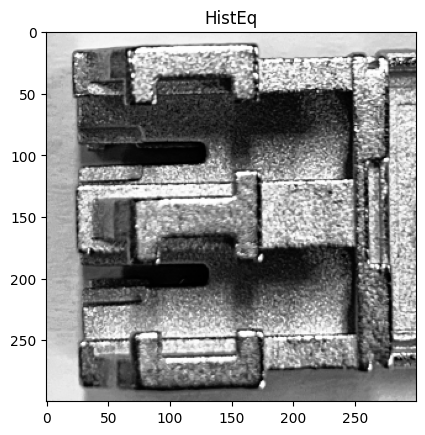

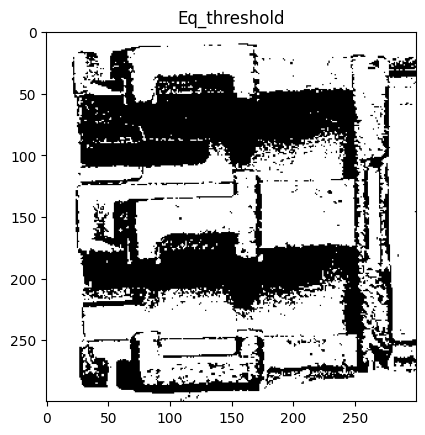

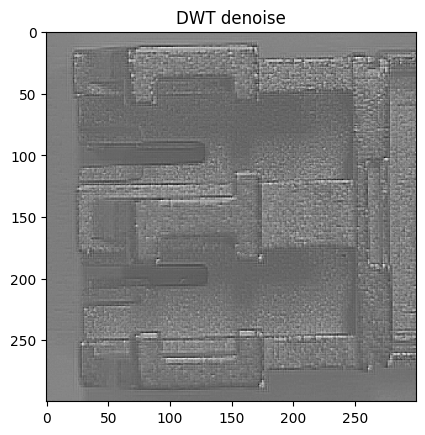

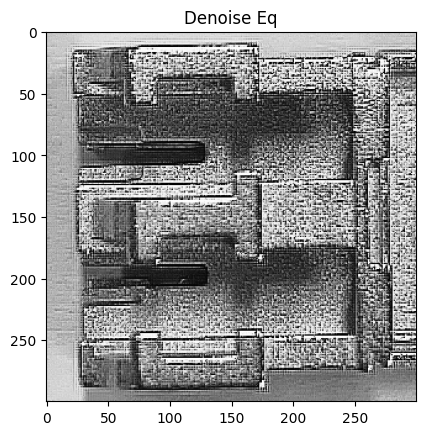

In [805]:
#Denoise kernel
[k1, k2, k3, k4] = [np.zeros([5,5]) for i in range(4)]                                                 
k1[0][4] = k1[1][3] = k1[3][1] = k1[4][0] = -1
k2[0][2] = k2[1][2] = k2[3][2] = k2[4][2] = -1
k3[0][0] = k3[1][1] = k3[3][3] = k3[4][4] = -1
k1[2][2] = k2[2][2] = k3[2][2] = k4[2][2] = 4
k4[3][0] = k4[3][1] = k4[3][3] = k4[4][3] = -1

from scipy import signal
LL,(HL,LH,HH) = pywt.dwt2(image,"haar")
LH_C= [np.zeros([LH.shape[0],LH.shape[1]]) for i in range(4)]  
HL_C = [np.zeros([HL.shape[0],HL.shape[1]]) for i in range(4)]  
HH_C = [np.zeros([HH.shape[0],HH.shape[1]]) for i in range(4)]  
for i, element in enumerate([k1,k2,k3,k4]):
    LH_C[i] =  signal.convolve2d(LH, element, boundary='symm', mode='same')
    HL_C[i] =  signal.convolve2d(HL, element, boundary='symm', mode='same')
    HH_C[i] =  signal.convolve2d(HH, element, boundary='symm', mode='same')


#Choose the median of the kernel denoise

LH_C = np.array(LH_C)
HL_C = np.array(HL_C)
HH_C = np.array(HH_C)

LH_A = np.min(LH_C,axis=0)
#LH_A[LH_A>=255] = np.median(LH)
#LH_A[LH_A<=0] = np.median(LH)
HL_A = np.min(HL_C,axis=0)
#HL_A[HL_A>=255] = np.median(HL)
#HL_A[HL_A<=0] = np.median(HL)
HH_A = np.min(HH_C,axis=0)
#HH_A[HH_A>=255] = np.median(HH)
#HH_A[HH_A<=0] = np.median(HH)

z = np.zeros([LL.shape[0],LL.shape[1]])
re_img = pywt.idwt2((LL,(HL_A,LH_A,HH_A)),"haar")
re_img = 255*(re_img-np.min(re_img))/(np.max(re_img)-np.min(re_img))
re_img = re_img.astype(np.uint8)
plt.title("DWT denoise")
plt.imshow(re_img, cmap='gray')
plt.show()
Dimage_eq = cv2.equalizeHist(re_img)
plt.title("Denoise Eq")
plt.imshow(Dimage_eq, cmap='gray', vmin = 0, vmax = 255)
plt.show()

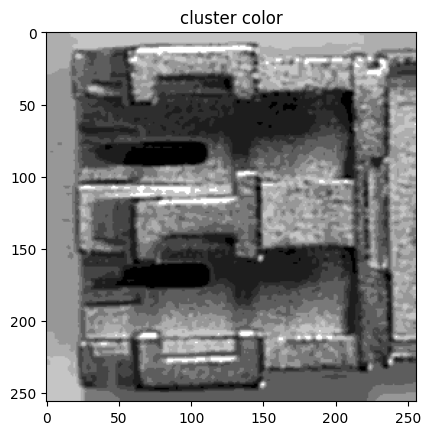

[[127 127 127 ... 127 127 127]
 [127 127 127 ... 127 127 127]
 [127 127 127 ... 127 127 127]
 ...
 [131 131 131 ... 123 123 123]
 [131 131 131 ... 123 123 123]
 [131 131 131 ... 123 123 123]]


In [766]:
# color patch

from sklearn.cluster import KMeans
cluster = 10
image_blur = cv2.GaussianBlur(re_img, (7, 7), 0)
x = image_blur.reshape(-1, 1)
kmeans = KMeans(n_clusters=cluster)
kmeans.fit(x)
y_kmeans = kmeans.predict(x).reshape(image.shape[0],-1)
output = np.zeros(image_blur.shape)
for i in range(cluster):
    f = y_kmeans==i
    output[f]=kmeans.cluster_centers_[i] 
output = output.astype(np.uint8)
plt.title("cluster color")
plt.imshow(output, cmap='gray')
plt.show()
print(output)

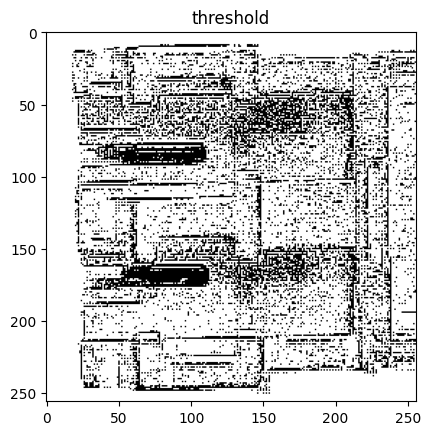

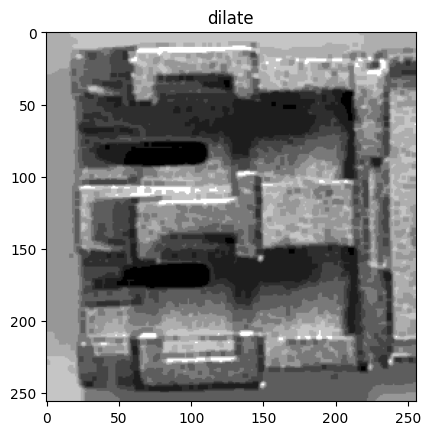

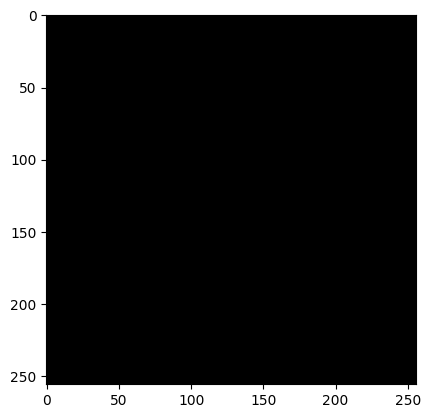

In [800]:
#white erode

_,re_img_hist_t = cv2.threshold(Dimage_eq, 60, 255, cv2.THRESH_BINARY)
plt.title("threshold")
plt.imshow(re_img_hist_t, cmap='gray')
plt.show()

kernel = np.ones((3,3), np.uint8)
dilation = cv2.morphologyEx(output, cv2.MORPH_CLOSE, kernel, iterations=1)

plt.title("dilate")
plt.imshow(dilation, cmap='gray')
plt.show()


canny = sobel(output)
plt.imshow(canny, cmap='gray', vmin = 0, vmax = 255)
plt.show()

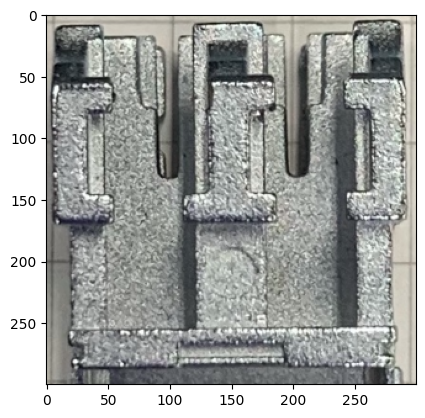

In [801]:
import cv2
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

fileName1 = "/Users/laiyiying/Documents/110-image/IMG_4809.jpg"
image = cv2.imread(fileName1)
image = cv2.resize(image, (300, 300), interpolation=cv2.INTER_AREA)
plt.imshow(image)
plt.show()

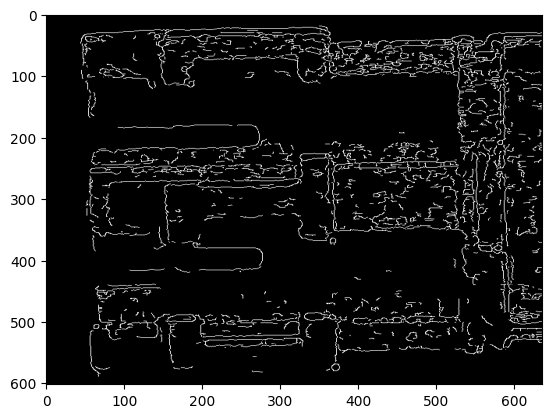

In [623]:
image = cv2.imread("IMG_4809.jpg")
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
#blurred = cv2.GaussianBlur(re_img, (3, 3), 0)
canny = cv2.Canny(blurred, 20, 30)
plt.imshow(canny, cmap='gray', vmin = 0, vmax = 255, aspect='auto')
plt.show()

[[1 1 1 ... 3 3 3]
 [4 1 1 ... 3 3 3]
 [4 4 4 ... 3 3 3]
 ...
 [4 4 4 ... 3 3 3]
 [4 4 4 ... 3 3 3]
 [4 4 1 ... 3 3 3]]


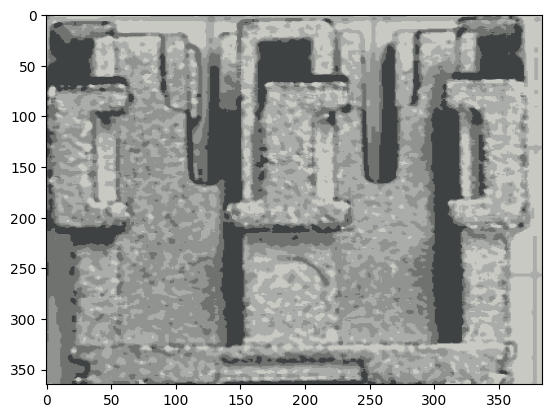

In [70]:
from sklearn.cluster import KMeans
image = cv2.imread("IMG_4809_c.jpg")
cluster = 5
image = cv2.medianBlur(image, 5)
x = image.reshape(-1, 3)
kmeans = KMeans(n_clusters=cluster)
kmeans.fit(x)
y_kmeans = kmeans.predict(x).reshape(image.shape[0],-1)
print(y_kmeans)
output = np.zeros(image.shape)
for i in range(cluster):
    f = y_kmeans==i
    output[f]=kmeans.cluster_centers_[i] 
output = output.astype(np.uint8)
#output = cv2.medianBlur(output, 5)
plt.imshow(output, aspect='auto')
plt.show()

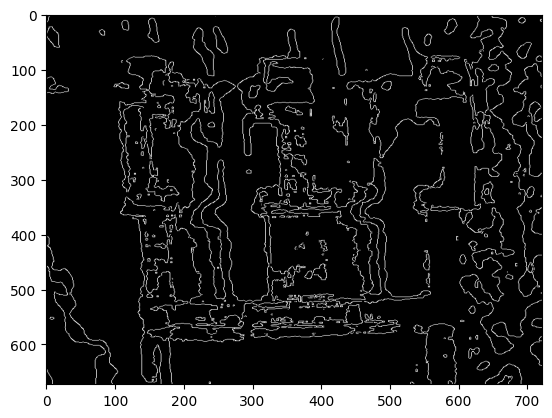

In [608]:
image = cv2.imread("/Users/laiyiying/Documents/110-image/IMG_4892.jpg")
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
blur = cv2.medianBlur(gray, 5)
canny = cv2.Canny(blurred,30, 120)

plt.imshow(canny, cmap='gray', vmin = 0, vmax = 255, aspect='auto')
plt.show()

In [71]:
import pywt

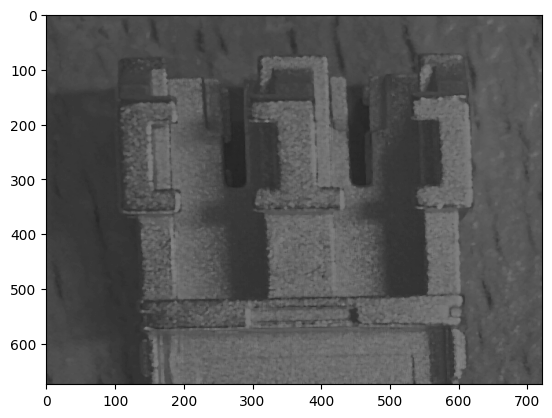

In [494]:
image = cv2.imread("/Users/laiyiying/Documents/110-image/IMG_4907.jpg")
#image = cv2.medianBlur(image, 5)
image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
LL,(HL,LH,HH) = pywt.dwt2(image,"haar")
plt.imshow(re_img, cmap='gray', vmin = 0, vmax = 255, aspect='auto')
plt.show()

In [495]:
[k1, k2, k3, k4] = [np.zeros([5,5]) for i in range(4)]                                                 
k1[0][4] = k1[1][3] = k1[3][1] = k1[4][0] = -1
k2[0][2] = k2[1][2] = k2[3][2] = k2[4][2] = -1
k3[0][0] = k3[1][1] = k3[3][3] = k3[4][4] = -1
k1[2][2] = k2[2][2] = k3[2][2] = k4[2][2] = 4
k4[3][0] = k4[3][1] = k4[3][3] = k4[4][3] = -1

In [496]:
from scipy import signal
LH_C= [np.zeros([LH.shape[0],LH.shape[1]]) for i in range(4)]  
HL_C = [np.zeros([HL.shape[0],HL.shape[1]]) for i in range(4)]  
HH_C = [np.zeros([HH.shape[0],HH.shape[1]]) for i in range(4)]  
for i, element in enumerate([k1,k2,k3,k4]):
    LH_C[i] =  signal.convolve2d(LH, element, boundary='symm', mode='same')
    HL_C[i] =  signal.convolve2d(HL, element, boundary='symm', mode='same')
    HH_C[i] =  signal.convolve2d(HH, element, boundary='symm', mode='same')

In [497]:
LH_C = np.array(LH_C)
HL_C = np.array(HL_C)
HH_C = np.array(HH_C)

LH_A = np.median(LH_C,axis=0)//2+128
#LH_A[LH_A>=255] = np.median(LH)
#LH_A[LH_A<=0] = np.median(LH)
HL_A = np.median(HL_C,axis=0)//2+128
#HL_A[HL_A>=255] = np.median(HL)
#HL_A[HL_A<=0] = np.median(HL)
HH_A = np.median(HH_C,axis=0)//2+128
#HH_A[HH_A>=255] = np.median(HH)
#HH_A[HH_A<=0] = np.median(HH)

[[174.  86. 113. ... 157. 105. 125.]
 [158.  86. 132. ... 145.  89. 127.]
 [149.  79. 130. ... 137. 114. 140.]
 ...
 [104. 146. 137. ...  91. 124. 138.]
 [106. 140. 135. ...  91. 123. 136.]
 [103. 134. 144. ...  90. 121. 136.]]
[[124. 117. 127. ... 108. 122. 113.]
 [161. 131. 150. ... 153. 160. 149.]
 [104. 100.  95. ... 133. 135. 149.]
 ...
 [131. 136. 124. ... 129. 128. 127.]
 [129. 124. 125. ... 127. 127. 128.]
 [127. 126. 127. ... 127. 127. 128.]]
[[116. 133. 128. ... 129. 115. 125.]
 [150. 126. 121. ... 131. 146. 140.]
 [116. 138. 128. ... 123. 103. 119.]
 ...
 [125. 129. 130. ... 126. 128. 129.]
 [130. 128. 126. ... 127. 128. 128.]
 [127. 128. 127. ... 127. 127. 127.]]


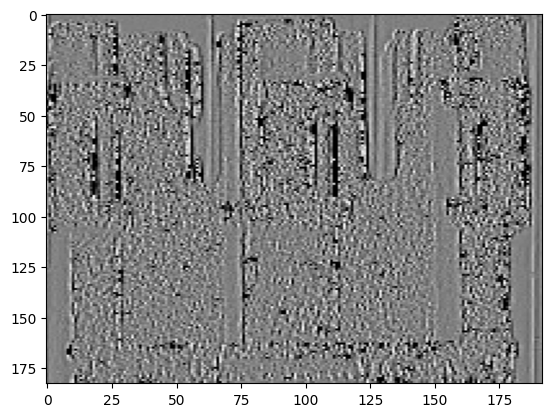

In [190]:
print(HL_A)
print(LH_A)
print(HH_A)
plt.imshow(HL_A, cmap='gray', vmin = 0, vmax = 255, aspect='auto')
plt.show()

In [191]:
LH_A = (LH_A-128)*2
HL_A = (HL_A-128)*2
HH_A = (HH_A-128)*2


[[-24.  10.   0. ...   2. -26.  -6.]
 [ 44.  -4. -14. ...   6.  36.  24.]
 [-24.  20.   0. ... -10. -50. -18.]
 ...
 [ -6.   2.   4. ...  -4.   0.   2.]
 [  4.   0.  -4. ...  -2.   0.   0.]
 [ -2.   0.  -2. ...  -2.  -2.  -2.]]


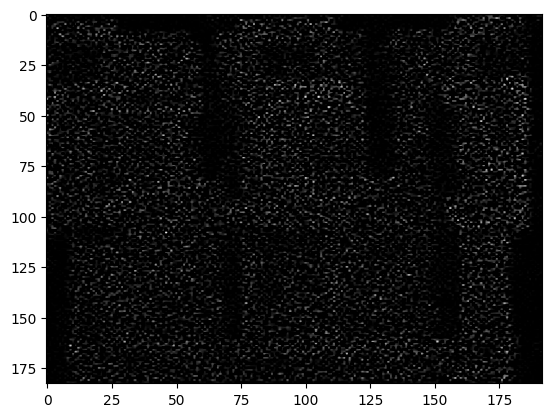

In [192]:
plt.imshow(HH_A, cmap='gray', vmin = 0, vmax = 255, aspect='auto')
plt.show()

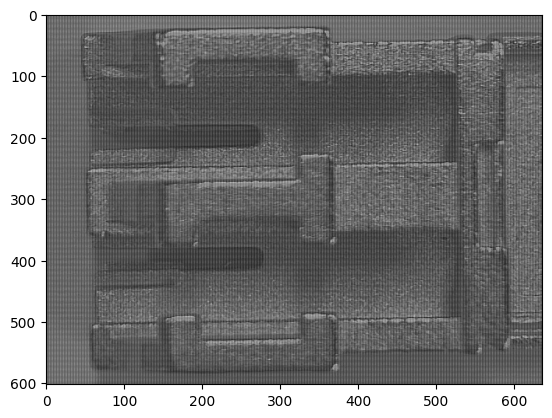

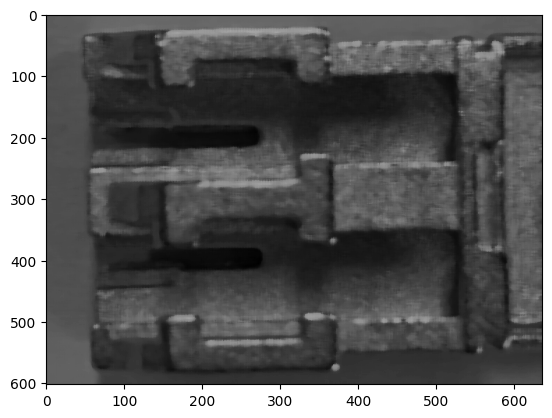

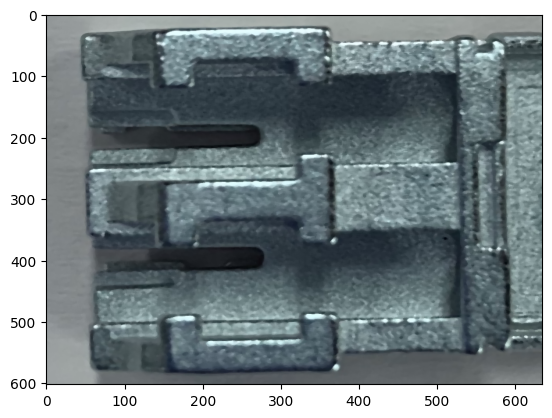

In [577]:
z = np.zeros([LL.shape[0],LL.shape[1]])
re_img = pywt.idwt2((LL,(HL_A,LH_A,HH_A)),"haar")
re_img = 255*(re_img-np.min(re_img))/(np.max(re_img)-np.min(re_img))
re_img = re_img.astype(np.uint8)
plt.imshow(re_img, cmap='gray', aspect='auto')
plt.show()

re_img = cv2.medianBlur(re_img,9)
plt.imshow(re_img, cmap='gray', aspect='auto')
plt.show()

plt.imshow(image, cmap='gray', aspect='auto')
plt.show()

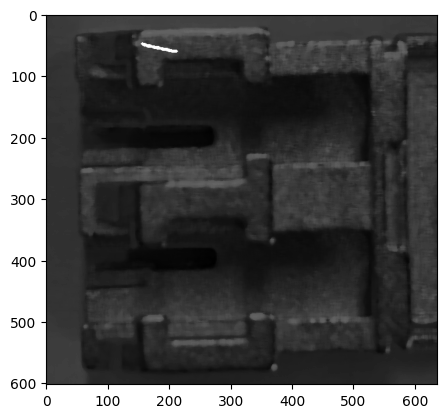

In [603]:
s1 = np.linspace(0, 50 ,50)
s2 = np.linspace(0, 150 ,50)
x1 = 40+s1
x2 = 120+s2
init = np.array([x2, x1]).T
snake = active_contour(re_img, init, w_edge=0, w_line=1)
snake = snake.astype(np.int32).reshape(-1,1,2)
#drawing = np.zeros((re_img.shape[0], re_img.shape[1], 3), dtype=np.uint8)
image_draw = re_img.copy()
CountersImg = cv2.drawContours(image_draw,[snake], -1, (255,255,0),3)
plt.imshow(CountersImg,cmap=plt.cm.gray)
plt.show()

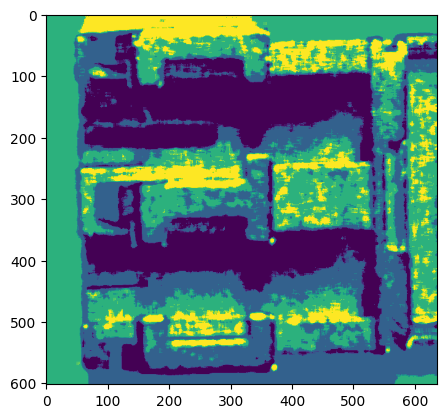

[[ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 ...
 [ 0  0  0 ... 11 11 11]
 [ 0  0  0 ... 11 11 11]
 [ 0  0  0 ... 11 11 11]]
[[[148 161 161]
  [148 161 161]
  [148 161 161]
  ...
  [148 161 161]
  [148 161 161]
  [148 161 161]]

 [[148 161 161]
  [148 161 161]
  [148 161 161]
  ...
  [148 161 161]
  [148 161 161]
  [148 161 161]]

 [[148 161 161]
  [148 161 161]
  [148 161 161]
  ...
  [148 161 161]
  [148 161 161]
  [148 161 161]]

 ...

 [[148 161 161]
  [148 161 161]
  [148 161 161]
  ...
  [130 149 152]
  [130 149 152]
  [130 149 152]]

 [[148 161 161]
  [148 161 161]
  [148 161 161]
  ...
  [130 149 152]
  [130 149 152]
  [130 149 152]]

 [[148 161 161]
  [148 161 161]
  [148 161 161]
  ...
  [130 149 152]
  [130 149 152]
  [130 149 152]]]


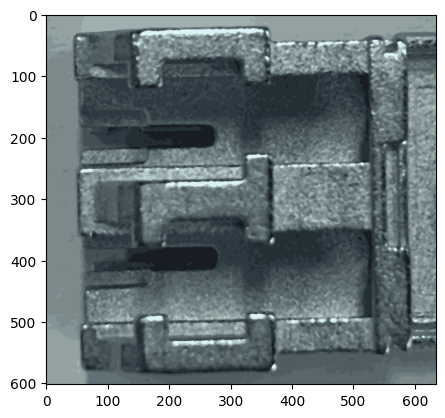

In [524]:
cluster = 4
#image = cv2.medianBlur(image, 5)
x = re_img.reshape(-1, 1)
kmeans = KMeans(n_clusters=cluster)
kmeans.fit(x)
y_kmeans = kmeans.predict(x).reshape(re_img.shape[0],-1)
output = np.zeros(re_img.shape)
for i in range(cluster):
    f = y_kmeans==i
    output[f]=kmeans.cluster_centers_[i] 
output = output.astype(np.uint8)
#output = cv2.medianBlur(output, 5)
plt.imshow(output)
plt.show()


#image = cv2.medianBlur(image, 5)
image = cv2.imread("/Users/laiyiying/Documents/110-image/IMG_4907.jpg")
cluster = 15
image = cv2.medianBlur(image, 5)
x = image.reshape(-1, 3)
kmeans = KMeans(n_clusters=cluster)
kmeans.fit(x)
y_kmeans = kmeans.predict(x).reshape(image.shape[0],-1)
print(y_kmeans)
output2 = np.zeros(image.shape)
for i in range(cluster):
    f = y_kmeans==i
    output2[f]=kmeans.cluster_centers_[i] 
output2 = output2.astype(np.uint8)
print(output2)
plt.imshow(output2)
plt.show()

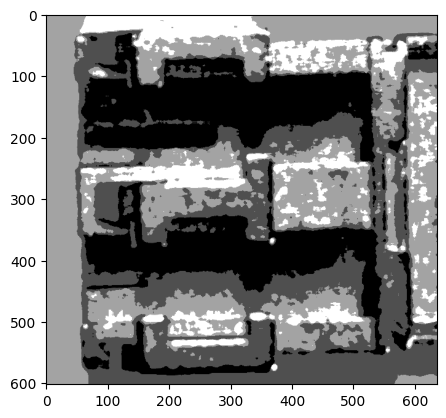

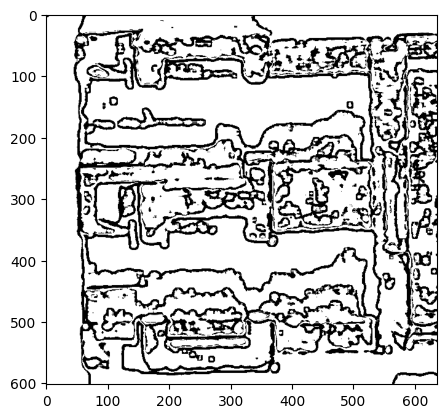

In [525]:
#ret2,re_img_hist = cv2.threshold(output2,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
#output2_g = cv2.cvtColor(output2, cv2.COLOR_BGR2GRAY)
re_img_hist = cv2.medianBlur(output,3)
plt.imshow(re_img_hist,cmap='gray')
plt.show()
re_img_hist_t = cv2.adaptiveThreshold(re_img_hist,255,cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY,11,2)
plt.imshow(re_img_hist_t,cmap=plt.cm.gray)
plt.show()

In [557]:
contours,hierarchy = cv2.findContours(re_img_hist_t,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
drawing = np.zeros((re_img_hist.shape[0], re_img_hist.shape[1], 3), dtype=np.uint8)
CountersImg = cv2.drawContours(drawing,contours, -1, (255,255,0),3)

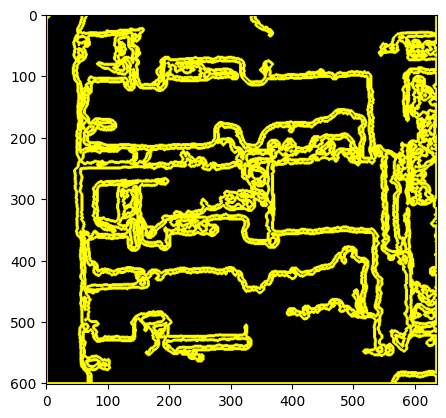

In [529]:
plt.imshow(CountersImg)

In [569]:
contours = [contour for contour in contours if len(contour)>100]
print(contours)

[array([[[309, 526]],

       [[308, 527]],

       [[306, 527]],

       [[305, 528]],

       [[299, 528]],

       [[299, 529]],

       [[298, 530]],

       [[297, 529]],

       [[297, 528]],

       [[297, 529]],

       [[296, 530]],

       [[295, 529]],

       [[295, 528]],

       [[295, 529]],

       [[294, 530]],

       [[293, 529]],

       [[292, 529]],

       [[291, 528]],

       [[287, 528]],

       [[286, 529]],

       [[285, 528]],

       [[284, 529]],

       [[281, 529]],

       [[281, 530]],

       [[280, 531]],

       [[278, 531]],

       [[277, 530]],

       [[276, 531]],

       [[275, 530]],

       [[272, 530]],

       [[271, 529]],

       [[270, 530]],

       [[269, 529]],

       [[268, 530]],

       [[267, 529]],

       [[266, 530]],

       [[265, 529]],

       [[264, 530]],

       [[261, 530]],

       [[260, 529]],

       [[259, 529]],

       [[258, 530]],

       [[251, 530]],

       [[250, 529]],

       [[249, 529]],

       [[

In [510]:
print(len(contours))

10


In [570]:
print(contours[0].shape)

(174, 1, 2)


In [568]:
print(snake.shape)

(100, 1, 2)
